# Ground-up experiment

An experiment where I simulate a planet population and attempt to infer the occurrence rate from the ground up.

Start with a synthetic stellar catalogue. The important things here are stellar radius (to calculate the transit probability) and apparant magnitude (to calculate a proxy for the CDPP/noise). I could also include things like youth/activity, but I'll skip that for now. I also need to include stellar mass in order to convert period into semi-major axis and calculate geometric transit probability. I am also not using a stellar evolution track to calculate stellar properties -- these things are random for now.

In [318]:
import scipy.special as sps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [319]:
nstars = 1000
id = range(nstars)

kepmag = 1*np.random.randn(nstars) + 15

# Keep the radii big so the transit probabilties are high.
radius = np.exp(.01 * np.random.randn(nstars) + 5)
mass = radius

In [320]:
stars = pd.DataFrame(dict({"kepid": id, "kepmag": kepmag, "radius": radius, "mass": mass}))


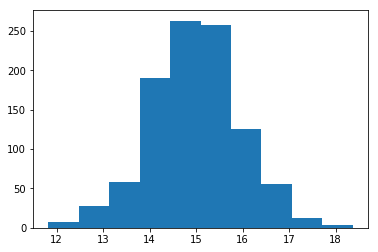

In [321]:
plt.hist(stars.kepmag);

Now simulate a population of planets (in this example, every star has a planet).

In [322]:
# Set ranges on planet radius, orbital period and kepler magnitude.
min_rad, max_rad = .5, 10
min_per, max_per = .5, 100
min_kepmag, max_kepmag = 12, 17.5

# remove stars outside these values
m = min_kepmag < stars.kepmag.values
m &= stars.kepmag.values < max_kepmag
stars = stars.iloc[m]

nstars = len(stars)
nplanets = nstars  # Every star has a planet

prad = np.random.uniform(min_rad, max_rad, nplanets)  # Uniform radius distribution
p_orb = np.random.uniform(min_per, max_per, nplanets)  # Uniform period distribution

all_kois = pd.DataFrame(dict({"kepid": stars.kepid, "kepmag": stars.kepmag, 
                              "radius": stars.radius, "mass": stars.mass, 
                              "prad": prad, "p_orb": p_orb}))


But not all these planets are observed -- some are censored because of the noise. This censorship is a function of Kepler magnitude, planet radius and orbital period. You're less likely to observe a planet the noisier the signal is.

Text(0,0.5,'detection prob f(kepmag)')

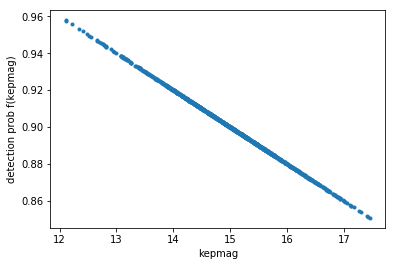

In [323]:
pdetect_noise = -.02* stars.kepmag.values + 1.2
plt.plot(stars.kepmag.values, pdetect_noise, ".")  # Add 1 to keep value between zero and one.
plt.xlabel("kepmag")
plt.ylabel("detection prob f(kepmag)")


Text(0,0.5,'detection prob f(prad)')

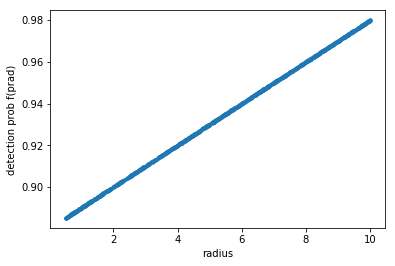

In [324]:
pdetect_radius = .01 * all_kois.prad.values + .88
plt.plot(all_kois.prad.values, pdetect_radius, ".")  # Add 1 to keep value between zero and one.
plt.xlabel("radius")
plt.ylabel("detection prob f(prad)")

Text(0,0.5,'detection prob f(porb)')

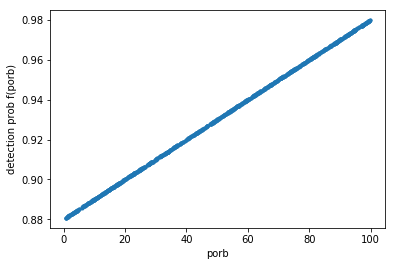

In [325]:
pdetect_porb = .001 * all_kois.p_orb.values + .88
plt.plot(all_kois.p_orb.values, pdetect_porb, ".")  # Add 1 to keep value between zero and one.
plt.xlabel("porb")
plt.ylabel("detection prob f(porb)")

The total detection probability (not accounting for geometric transit prob) is the sum of these three probabilities.

Text(0.5,0,'detection probability')

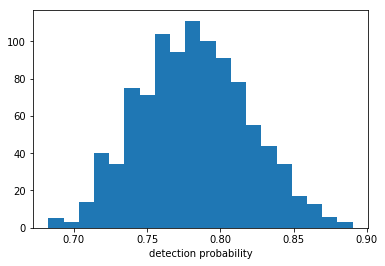

In [326]:
pdetect = pdetect_noise * pdetect_radius * pdetect_porb
plt.hist(pdetect, 20);
plt.xlabel("detection probability")

Then there's also the geometric transit probability.

Text(0.5,0,'Transit probability')

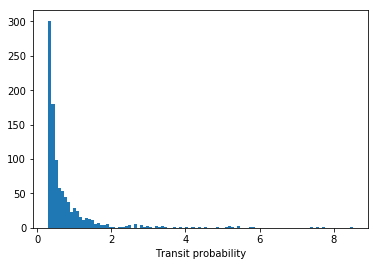

In [377]:
import astropy.constants as co
import astropy.units as u

def kepler3(period, mass):
    """
    Calculate semi-major axis. Takes period in days and mass in Solar masses.
    Returns semi-major axis in m.
    Tested. (Returns 1 AU for 1 year and Solar mass.)
    """
    p = period*24*3600
    m = mass * co.M_sun.value
    return (p**2 * co.G.value * m / (4*np.pi**2))**(1./3.)

def ptrans(stlr_rad_rsun, period_days, mass_msun):
    a_m = kepler3(period_days, mass_msun)
    return stlr_rad_rsun*co.R_sun.value/a_m

ptransit = ptrans(all_kois.radius.values, all_kois.p_orb.values, all_kois.mass.values)
plt.hist(ptransit, 100);
plt.xlabel("Transit probability")


The product of these two probabilities gives the overall probability of detection.

Text(0.5,0,'ptot')

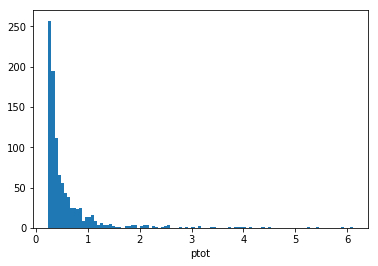

In [378]:
ptot = ptransit * pdetect
plt.hist(ptot, 100);
plt.xlabel("ptot")


Now, for each planet draw a random number between zero and one. If that number is less than the transit probability, then assign a planet to that star.

In [379]:
probs = np.random.uniform(0, 1, nstars)
m1 = np.zeros(nstars)
for i in range(nstars):
    if probs[i] < ptot[i]:
        m1[i] = 1
        
m = m1 == 1
kois = all_kois.iloc[m]
        

In [380]:
print(len(kois), len(all_kois))

490 992


So now my task is to infer the occurrence rate of planets (which is actually 1), given the true completeness model. To do this I need to calculate the completeness in each magnitude bin using the fact that I know how likely it is to detect a planet of a given size and period with a certain amount of noise.

To do this, integrate completeness across the parameters you're interested in.

At first, I'm just interested in how occurrence rate changes with apparent magnitude. (It should remain constant if our procedure is correct.) If I didn't need to integrate across bins this would be simple: for a single star I would just multiply its number of planets by the inverse detection efficiency for that star. At a given radius and orbital period, if a single planet is detected orbiting a star with a detection efficiency of 0.5 (meaning that in injection and recovery tests, half the Earth-sized planets are detected), that star is likely to actually have two planets.

Since the detection efficiency is a function of planet size and orbital period, not just S/N, one must integrate over a range of planet periods and sizes as well as S/N values.

So I want bins in kepler magnitude, planet radius and planet size. For each star I want to simulate planets with a range of radii and orbital periods and evaluate the detection efficiency. I take the sum of these values and divide by the number of samples to get an approximation to the integrated detection efficiency over the bin.

Don't worry about the bins for now -- you'll calculate those when you take histograms at the end.

Define the completeness equations.

In [381]:
def det_prob(kepmag, rad_pl, per_pl, stlr_rad_rsun, stlr_mass_msun):
    
    # Detection probability
    pdet_kepmag = -.02* kepmag + 1.2
    pdet_rad = .01 * rad + .88
    pdet_per = .001 * per + .88
    
    # Transit probability
    ptransit = ptrans(stlr_rad_rsun, per_pl, stlr_mass_msun)
    
    return pdet_kepmag * pdet_rad * pdet_per * ptransit

In [416]:
from tqdm import tqdm 

nsamps = 2000
sumQ = np.zeros(nstars)
Qs = np.zeros((nstars, nsamps))

# Iterate over stars.
for i in tqdm(range(nstars)):
    
    # Simulate stars with a range of planet radii and orbital periods.
    rad = np.random.uniform(min_rad, max_rad, nsamps)
    per = np.random.uniform(min_per, max_per, nsamps)
    
    # Evaluate the detection probability for each star, summed over each radius and period.
    sumQ[i] = sum(det_prob(stars.kepmag.values[i], rad, per, 
                           stars.radius.values[i], 
                           stars.mass.values[i])) / nstars
    Qs[i, :] = (det_prob(stars.kepmag.values[i], rad, per, 
                         stars.radius.values[i], stars.mass.values[i]))

100%|██████████| 992/992 [00:00<00:00, 1614.25it/s]


992
992


Text(0,0.5,'Summed detection probability over sim planets')

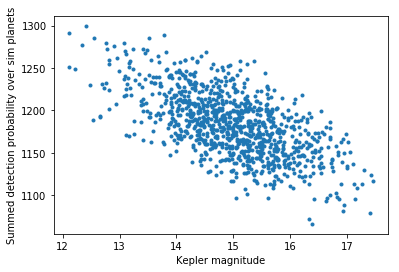

In [420]:
sumQt = np.sum(Qs, axis=1)
print(sum(sumQt == sumQ))
plt.plot(stars.kepmag, sumQ, ".")
print(nstars)
plt.xlabel("Kepler magnitude")
plt.ylabel("Summed detection probability over sim planets")

Text(0.5,0,'numerator')

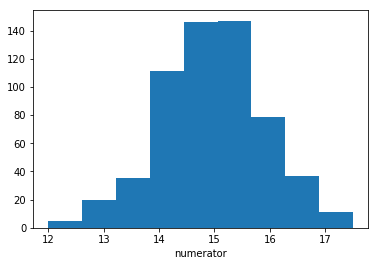

In [392]:
nbins = 10
kbins = np.linspace(min_kepmag, max_kepmag, nbins)
num, _ = np.histogram(stars.kepmag.values, bins=kbins, weights=sumQ)
plt.hist(stars.kepmag.values, bins=kbins, weights=sumQ);
plt.xlabel("numerator")

Normalise by the number of stars in each bin.

Text(0.5,0,'denominator')

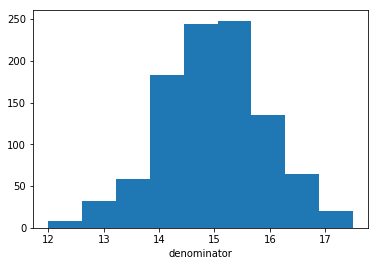

In [393]:
denom, _ = np.histogram(stars.kepmag.values, bins=kbins)
plt.hist(stars.kepmag.values, bins=kbins);
plt.xlabel("denominator")

Text(0,0.5,'Completeness')

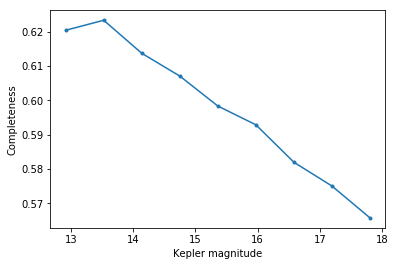

In [394]:
Q = num/denom
x = kbins[1:] + .5*np.diff(kbins)
plt.plot(x, Q, ".-")
plt.xlabel("Kepler magnitude")
plt.ylabel("Completeness")

This is the completeness -- it goes down as a function of kepmag.

<Container object of 3 artists>

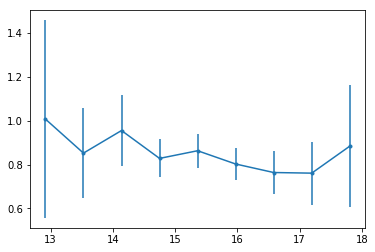

In [405]:
N_obs, _ = np.histogram(kois.kepmag.values, bins=kbins)
norm, _ = np.histogram(stars.kepmag.values, bins=kbins)

planets_per_star = N_obs / Q / norm
err = planets_per_star/np.sqrt(N_obs)

plt.errorbar(x, planets_per_star, yerr=err, fmt=".-")

Now look at occurrence rate as a function of planet radius.

In [409]:
# nsamps = 1000
# sumQr = np.zeros(len(kois))

# # Iterate over stars.
# for i in tqdm(range(len(kois))):
    
#     # Simulate stars with a range of planet radii and orbital periods.
#     radr = np.random.uniform(min_rad, max_rad, nsamps)
#     perr = np.random.uniform(min_per, max_per, nsamps)
    
#     # Evaluate the detection probability for each star, summed over each radius and period.
#     sumQr[i] = sum(det_prob(kois.kepmag.values[i], radr, perr, 
#                            kois.radius.values[i], 
#                            kois.mass.values[i])) / nplanets

100%|██████████| 490/490 [00:00<00:00, 2623.44it/s]


<Container object of 3 artists>

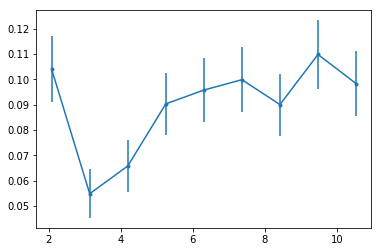

In [413]:
rbins = np.linspace(min_rad, max_rad, nbins)
numr, _ = np.histogram(stars.kepmag.values, bins=kbins, weights=sumQ)
denomr, _ = np.histogram(stars.kepmag.values, bins=kbins)
N_obsr, _ = np.histogram(kois.prad.values, bins=rbins)
normr = nstars

planets_per_starr = N_obsr / Qr / normr
errr = planets_per_starr/np.sqrt(N_obsr)

xr = rbins[1:] + .5*np.diff(rbins)
plt.errorbar(xr, planets_per_starr, yerr=errr, fmt=".-")